# Introduction

The purpose of this notebook is to visualise a literature review of the interactions between climate change and toothfish 


In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from bokeh.io import output_notebook,output_file, show, save
import networkx as nx
from bokeh.models import Range1d, Plot,  Range1d, Circle, ColumnDataSource, MultiLine, LabelSet, CustomJS, DataTable, TableColumn
from bokeh.plotting import from_networkx, curdoc, figure,show
from bokeh.models import HoverTool, TapTool 
from bokeh.palettes import Category20_20
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes, EdgesOnly
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.layouts import column, row




## Make an Interactive Network Visualization with Bokeh

https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html

This notebook includes code for creating interactive network visualizations with the Python libraries NetworkX and Bokeh. The notebook begins with code for a basic network visualization then progressively demonstrates how to add more information and functionality, such as:

- sizing and coloring nodes by degree

- sizing and coloring nodes by modularity class

- adding responsive highlighting when hovering over nodes and edges

- adding node labels

Bokeh: https://mybinder.org/v2/gh/bokeh/bokeh-notebooks/master?filepath=tutorial%2F00%20-%20Introduction%20and%20Setup.ipynb

In [24]:
output_notebook()

Loading BokehJS ...

In [25]:
 pd.read_csv('data/lit_rev_net.csv')

,from,to,interaction,certainty,references
0,prey variability,D. eleginoides adult growth,-1,hypothesized,"Subramaniam et al., 2020"
1,prey abundance: small fish,D. eleginoides adult growth,1,evidenced,"Barrera-Oro et al., 2005; Collins et al., 2007"
2,prey abundance: amphipods,D. eleginoides juvenile growth,1,evidenced,"Zhivov and Krivoruchko, 1990"
3,prey abundance: euphausids,D. eleginoides juvenile survival,1,evidenced,"Zhivov and Krivoruchko, 1990"
4,prey abundance: cephalopods,D. eleginoides adult growth,1,evidenced,"Pilling et al., 2001"
...,...,...,...,...,...
70,predator abundance: colossal squid,D. mawsoni adult survival,-1,evidenced,"Hatchet et al., 2015"
71,ocean acidity,D. mawsoni larvae/egg survival,-1,hypothesised,"Flynn et al., 2015"
72,on-shelf retention,D. mawsoni larvae/egg survival,1,hypothesised,"Mori et al., 2021; Behrens et al., 2021"
73,sea ice extent,D. mawsoni larvae/egg survival,1,hypothesised,"Hanchet et al., 2008; Hanchet et al., 2015b; P..."


## Function to create a networkx graph as well as node and edge attribute tables for use with bokeh

In [26]:
def bokeh_graph(path):
    df = pd.read_csv(path, encoding = "ISO-8859-1")
    G = nx.from_pandas_edgelist(df,df.columns[0],df.columns[1],edge_attr =True)
    
    #Re-name all nodes by an integer index for use in bokeh
    
    num_list = list(range(1, len(list(G.nodes))+1))
    #create a table of node names called parameters and num_list called index
    attri = pd.DataFrame({'node': list(G.nodes), 'index': num_list})
    #Transform dataframe into a dictionary
    node_attr = attri.set_index('node').to_dict('index')
    nx.set_node_attributes(G, node_attr)

    #Rename the nodes as integer indexes so that they work with Bokeh
    mapping = dict(zip(list(G.nodes), num_list))
    G = nx.relabel_nodes(G, mapping)

    # Add 'node' as node attributes
    for row in attri.itertuples(index=False):
        G.nodes[row.index]['node'] = row.node 
        
    #Add node type 'variable' (toothfish variable of interest) or
    # 'parameter' (A parameter that affects a variable)
    # Create the 'type' column based on the 'node' column
    attri['type'] = attri['node'].apply(lambda node: 'variable' if
                                    'growth' in node or 'survival' in node
                                    else 'clim' if 'climate' in node
                                    else 'parameter')
    # Add type to node attributes
    for row in attri.itertuples(index=False):
        G.nodes[row.index]['type'] = row.type    
       
    # Add basic graph statistics as node attributes
    degrees = dict(nx.degree(G))
    nx.set_node_attributes(G, name='degree', values=degrees)
    
     #Calculate Eigencentrality
    ec=nx.eigenvector_centrality(G, weight = None)

    # Add eigenvector centrality to the 'attri' table
    attri['eigen_cent'] = [ec[node] for node in attri['index']]
    # Add eigenvector centrality to node attributes
    nx.set_node_attributes(G, ec, "eigen_cent")

    #Extract attributes as a pd.dataframe
    attri = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
    
    #Extract edge attributes as an edge table

    edge_data = []
    for edge in G.edges(data=True):
        edge_entry = {'source': edge[0], 'target': edge[1]}
        edge_entry.update(edge[2])  # Add all attributes to the dictionary
        edge_data.append(edge_entry)
    edge_df = pd.DataFrame(edge_data)
    
    #rename the source and target as start and end
    edge_df.rename(columns={'source':'start', 'target':'end'},
          inplace=True)
    



    return(G,attri, edge_df)

    

In [27]:
G, ntable, etable = bokeh_graph('data/lit_rev_net.csv')

In [28]:
ntable

,index,node,type,degree,eigen_cent
1,1,prey variability,parameter,2,0.132744
2,2,D. eleginoides adult growth,variable,7,0.157802
3,3,prey abundance: small fish,parameter,1,0.034878
4,4,prey abundance: amphipods,parameter,1,0.016596
5,5,D. eleginoides juvenile growth,variable,3,0.075085
6,6,prey abundance: euphausids,parameter,3,0.167622
7,7,D. eleginoides juvenile survival,variable,14,0.435283
8,8,prey abundance: cephalopods,parameter,1,0.034878
9,9,predator abundance: penguins,parameter,1,0.026096
10,10,D. eleginoides adult survival,variable,11,0.118069


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


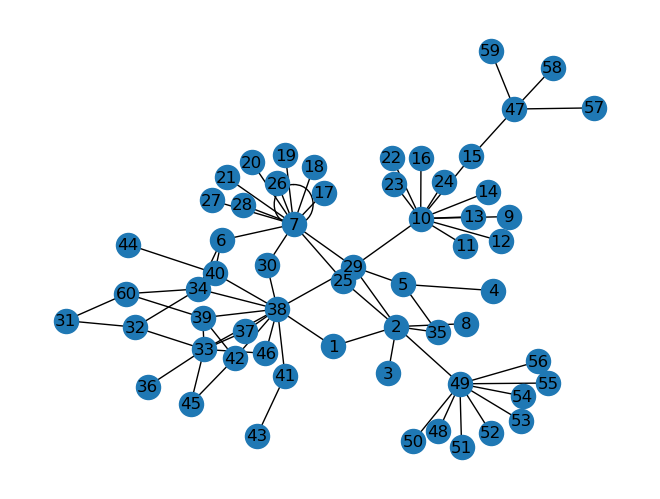

In [29]:

#check node attributes of G
nodes = G.nodes
print(nodes)
#simple plot of G
# Calculate the spring layout using NetworkX's spring_layout function
pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos,with_labels=True)
plt.show()

## Function to create a bokeh plot with node labels and a hovertool for ege attributes

In [30]:
def bplot(G, title, layout):
    
    title = title
    # Create a plot — set dimensions, toolbar, and title
    plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
                  x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1),
                  width=1000, height = 1000, title=title)
    curdoc().theme = 'caliber'
    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    graph = from_networkx(G, layout, scale=10, center=(0,0))
    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=15, fill_color='grey')
    graph.edge_renderer.glyph =  MultiLine(line_alpha=0.8, line_width=3)
    # blue hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=25, fill_color='#00FFFF')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#00FFFF', line_width=6)
    # When we hover over nodes, highlight adjecent edges too
    graph.inspection_policy = EdgesOnly()
    
    # Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [("References", "@references{safe}"),("Certainty","@certainty")]
    # Add HoverTool and TapTool to the plot
    #hover_tool = HoverTool(renderers=[graph], tooltips=HOVER_TOOLTIPS, line_policy='interp')
    #plot.add_tools(hover_tool)
    
  # Establish which categories will appear when hovering over each node using custom HTML
    HOVER_TOOLTIPS = """
        <div>
            <span style="font-size: 12px; color: #00FFFF; max-width: 200px; display: inline-block; vertical-align: top;">References:</span>
            <span style="font-size: 12px; max-width: 300px; display: inline-block;">@references</span>
        </div>
        <div>
            <span style="font-size: 12px; color: #00FFFF; max-width: 200px; display: inline-block;">Certainty:</span>
            <span style="font-size: 12px; max-width: 200px; display: inline-block;">@certainty</span>
        </div>
"""

    # Add HoverTool and TapTool to the plot
    hover_tool = HoverTool(renderers=[graph], tooltips=HOVER_TOOLTIPS, line_policy='interp')

    
    hover_tool = HoverTool(renderers=[graph], tooltips=HOVER_TOOLTIPS, line_policy='interp')
    plot.add_tools(hover_tool)

    #Add Labels
    x, y = zip(*graph.layout_provider.graph_layout.values())
    node_labels = [data for _, data in G.nodes('node')]
    lsource = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
    labels = LabelSet(x='x', y='y', text='name', source=lsource, background_fill_color='white', text_font_size='12px', background_fill_alpha=.8)
    plot.renderers.append(graph)
    plot.renderers.append(labels)
    return(plot, graph)



In [31]:
btest, bgraph =bplot(G,'test',nx.kamada_kawai_layout)
show(btest)


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


# Add edge and node attributes


In [32]:
G, ntable, etable = bokeh_graph('data/lit_rev_net.csv')

In [33]:
#G, ntable, etable
etable.head()

,start,end,interaction,certainty,references
0,1,2,-1,hypothesized,"Subramaniam et al., 2020"
1,1,38,1,hypothesized,"Subramaniam et al., 2020"
2,2,3,1,evidenced,"Barrera-Oro et al., 2005; Collins et al., 2007"
3,2,8,1,evidenced,"Pilling et al., 2001"
4,2,25,1,evidenced,"Arkhipkin et al., 2003"


In [34]:
etable.head()

,start,end,interaction,certainty,references
0,1,2,-1,hypothesized,"Subramaniam et al., 2020"
1,1,38,1,hypothesized,"Subramaniam et al., 2020"
2,2,3,1,evidenced,"Barrera-Oro et al., 2005; Collins et al., 2007"
3,2,8,1,evidenced,"Pilling et al., 2001"
4,2,25,1,evidenced,"Arkhipkin et al., 2003"


## Edge

In [35]:
#Edge colours
edge_attrs = {}
for edge in G.edges(data=True):
    edge_weight = edge[2]['interaction']
    if edge_weight == -1:
        edge_color=('red')
    elif edge_weight == 0:
        edge_color=('grey')
    else:
        edge_color=('green')
    edge_attrs[edge[:2]] = edge_color  # Assign color to the edge based on its source and target nodes
    
    nx.set_edge_attributes(G, edge_attrs, "edge_color")
    
#Edge styles
    edge_attrs = {}
for edge in G.edges(data=True):
    edge_weight = edge[2]['certainty']
    if edge_weight == 'evidenced':
        edge_style=('solid')
    else:
        edge_style=('dashed')
    edge_attrs[edge[:2]] = edge_style  # Assign color to the edge based on its source and target nodes
    
    nx.set_edge_attributes(G, edge_attrs, "edge_style")
    

    nx.set_edge_attributes(G, edge_attrs, "edge_width")
    

In [36]:
#Node size

 # Add size adjusted eigenvector centrality to the 'attri' table
ntable['eigen_size']= ntable['eigen_cent']*100
 #ecs = attri.set_index('index').to_dict('eigen_size')
nx.set_node_attributes(G, ntable['eigen_size'], "eigen_size")

number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree*number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
#size_by_this_attribute = 'eigen_size'
size_by_this_attribute = 'adjusted_node_size'

node_attrs = {}
for node in G.nodes(data=True):
    node_type = node[1]['type']
    if node_type == 'variable':
        node_colour = '#00FFFF'
    elif node_type == 'clim':
        node_colour='orange'
    else:
        node_colour = 'grey'
    node_attrs[node[0]] = node_colour  # Use node[0] to access the node ID and assign color

nx.set_node_attributes(G, node_attrs, "node_colour")

colour_by_this_attribute = 'node_colour'

In [37]:

bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.spring_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width= "edge_width")

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)
show(bnet)
save(bnet, filename="figures/draft_lit_net.html")


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\879271206.py:11: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(bnet, filename="figures/draft_lit_net.html")
C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\879271206.py:11: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(bnet, filename="figures/draft_lit_net.html")


'C:\\Users\\otibru\\OneDrive - NERC\\BAS\\sandbox\\figures\\draft_lit_net.html'

## Trial other layouts

In [39]:

bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.spring_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width=2)

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size=15, fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)
show(bnet)
save(bnet, filename="figures/draft_sizeless_lit_net.html")


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\1427027101.py:11: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(bnet, filename="figures/draft_sizeless_lit_net.html")
C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\1427027101.py:11: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(bnet, filename="figures/draft_sizeless_lit_net.html")


'C:\\Users\\otibru\\OneDrive - NERC\\BAS\\sandbox\\figures\\draft_sizeless_lit_net.html'

In [17]:

bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.spring_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width=2)

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size='eigen_size', fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)
show(bnet)
save(bnet, filename="figures/draft_eigen_lit_net.html")


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\986136352.py:11: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(bnet, filename="figures/draft_eigen_lit_net.html")
C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\986136352.py:11: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(bnet, filename="figures/draft_eigen_lit_net.html")


'C:\\Users\\otibru\\OneDrive - NERC\\BAS\\sandbox\\figures\\draft_eigen_lit_net.html'

In [18]:

bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.spring_layout(G, k=1/len(G)**0.5))
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width=2)

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size='eigen_size', fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)
show(bnet)
#save(bnet, filename="figures/draft_mawsoni_climate_handbook.html")


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


In [19]:

bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.kamada_kawai_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width=2)

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size='eigen_size', fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)
show(bnet)
#save(bnet, filename="figures/draft_mawsoni_climate_handbook.html")


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


In [20]:

bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.spectral_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width=2)

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size='eigen_size', fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)
show(bnet)
#save(bnet, filename="figures/draft_mawsoni_climate_handbook.html")


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


In [21]:

bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.shell_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width="edge_width")

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size='eigen_size', fill_color =colour_by_this_attribute)


# Add network graph to the plot
bnet.renderers.append(bgraph)
show(bnet)
save(bnet, filename="figures/draft_lit_net_shell.html")


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\890100919.py:12: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(bnet, filename="figures/draft_lit_net_shell.html")
C:\Users\otibru\AppData\Local\Temp\ipykernel_24176\890100919.py:12: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(bnet, filename="figures/draft_lit_net_shell.html")


'C:\\Users\\otibru\\OneDrive - NERC\\BAS\\sandbox\\figures\\draft_lit_net_shell.html'

### Add a table to the plot

In [22]:
etable.head()

,start,end,interaction,certainty,references
0,1,2,-1,hypothesized,"Subramaniam et al., 2020"
1,1,39,1,hypothesized,"Subramaniam et al., 2020"
2,2,3,1,evidenced,"Barrera-Oro et al., 2005; Collins et al., 2007"
3,2,8,1,evidenced,"Pilling et al., 2001"
4,2,25,1,evidenced,"Arkhipkin et al., 2003"


In [56]:


bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.spring_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width=2)

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size='eigen_size', fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)



# Create a ColumnDataSource from the edge DataFrame
source = ColumnDataSource(data=etable)

# Create a DataTable source	target	weight	certainty	references
columns = [
   
    TableColumn(field="link", title="Links")
]
dt = DataTable(source=source, columns=columns, width=700, height=400)

# Combine the network graph and DataTable into a layout
layout = column(bnet, dt)

# Specify the output file and save the plot
output_file("figures/draft_eleginoides_table.html", title="JS Events Example")
save(layout)

# Show the plot (if needed)
#show(layout)

#show(column(bnet,dt))
#save(column(bnet,dt), filename="figures/draft_eleginoides_table.html")

C:\Users\otibru\AppData\Local\Temp\ipykernel_25352\2919942440.py:10: UserWarning: Converting node attributes labeled 'index' are skipped. If you want to convert these attributes, please re-label with other names.
  graph = from_networkx(G, layout, scale=10, center=(0,0))


'C:\\Users\\otibru\\OneDrive - NERC\\BAS\\sandbox\\figures\\draft_eleginoides_table.html'

In [57]:
 refs=pd.read_csv('data/int_net_ref_d.csv')

In [58]:
refs

,ref.,reference,link
0,"Coppola et al., 2015","Coppola, D., Giordano, D., Abbruzzetti, S., Ma...",https://link.springer.com/article/10.1007/s107...
1,NaN,"Lõhmus, M. and Björklund, M., 2015. Climate ch...",NaN


In [ ]:


bnet, bgraph =bplot(G,'D. mawsoni climate (handbook) interactions',nx.spring_layout)
# Set edge colour and type
bgraph.edge_renderer.glyph = MultiLine(line_color="edge_color",line_dash= "edge_style", line_alpha=0.8, line_width=2)

#Set node sizes and colors according to node degree (color as category from attribute)
bgraph.node_renderer.glyph = Circle(size='eigen_size', fill_color =colour_by_this_attribute)

# Add network graph to the plot
bnet.renderers.append(bgraph)



# Create a ColumnDataSource from the edge DataFrame
source = ColumnDataSource(data=refs)

# Create a DataTable 
columns = [
    TableColumn(field="ref.", title="in-text"),
    TableColumn(field="reference", title="Reference"),
    TableColumn(field="link", title="Link")
]
dt = DataTable(source=source, columns=columns, width=700, height=400)

# Combine the network graph and DataTable into a layout
layout = column(bnet, dt)

# Specify the output file and save the plot
output_file("figures/draft_eleginoides_ref.table.html", title="JS Events Example")
save(layout)

# Show the plot (if needed)
#show(layout)

#show(column(bnet,dt))
#save(column(bnet,dt), filename="figures/draft_eleginoides_table.html")